In [1]:
# "nbsphinx": "hidden"
import os

os.chdir("../../../tests/datasets")


# prevent write the galaxy into disk
from unittest import mock

patch = mock.patch("galaxychop.core.data.Galaxy.to_hdf5", return_value=None)
patch.start();

# Understanding the GalaxyChop Galaxies
GalaxyChop was designed around the definition of a Galaxy class, which encapsulates all the physical properties useful for the dynamic decomposition.

This chapter aims to explain the functionalities of a class Galaxy, which is represented with a class called `galaxychop.Galaxy`.

This tutorial will help the user to:

- Build a galaxy object 
- Understand deeply the Galaxy Class (attributes, properties and methods)

## 1. Creating the galaxy object
To create an object of type `Galaxy`, it is necessary to collect data from a single galaxy. The data should include stellar, dark matter, and gas particles, with their masses (`m`), positions (`x`, `y`, `z`), and velocities (`vx`, `vy`, `vz`).

There are several alternatives to load the `Galaxy` object:

- **Load Data Manually**: Manually input the required data.
- **Read Data from an npy File**: Load data from an npy file.
- **Read Data from an HDF5 File**: Retrieve data from an HDF5 file.

So, first of all, it is necessary to obtain a file with the appropriate content.

<div class="alert alert-warning">
**Note: Units**

To create a galaxy object, the data must be entered with units.

If you don't provide a unit, `Galaxychop` will assign:

- Solar Mass ($M\odot$) for Masses.
- Kiloparsec ($kpc$) for Positions.
- $Km/s$ for velocities.
- $(Km/s)^2$ for energy.

Finally, if the user provides a unit internally during calculations, the values will be converted to the default units.

For more information, please refer to the documentation of [Astropy Units](https://docs.astropy.org/en/stable/units/).
</div>


<div class="alert alert-info">
**Note: Files**

All the files used in this tutorial can be found 
[here](https://github.com/vcristiani/galaxy-chop/raw/master/tests/datasets/gal394242.h5).

For convenience, we have placed the files in the same folder where this tutorial is located.
</div>

### Load data manually

In this example, we demonstrate how to load data from three different files, each containing information for a specific type of particle (star, gas, and dark matter). Each file includes data on mass, positions, and velocities for each particle.

After that, we will create our `Galaxy` object using the [mkgalaxy()](../api/core/data.rst#galaxychop.core.data.mkgalaxy) function.


In [2]:
import numpy as np
import galaxychop as gchop

star = np.load("star_ID_394242.npy")
dark = np.load("dark_ID_394242.npy")
gas = np.load("gas_ID_394242.npy")

gal = gchop.mkgalaxy(
    m_s=star[:, 0],
    x_s=star[:, 1],
    y_s=star[:, 2],
    z_s=star[:, 3],
    vx_s=star[:, 4],
    vy_s=star[:, 5],
    vz_s=star[:, 6],
    m_dm=dark[:, 0],
    x_dm=dark[:, 1],
    y_dm=dark[:, 2],
    z_dm=dark[:, 3],
    vx_dm=dark[:, 4],
    vy_dm=dark[:, 5],
    vz_dm=dark[:, 6],
    m_g=gas[:, 0],
    x_g=gas[:, 1],
    y_g=gas[:, 2],
    z_g=gas[:, 3],
    vx_g=gas[:, 4],
    vy_g=gas[:, 5],
    vz_g=gas[:, 6],
)
gal

<Galaxy stars=32067, dark_matter=21156, gas=4061, potential=False>

#### Specific Potential Energy

Specific Potential Energy can be calculated or loaded according to user requirements:

##### Calculating specific potential energy

The package allows the calculation of the specific potential energy of each particle.

Using the [preproc.potential()](../api/preproc/potential_energy/potential_energy.inc) function, users can choose between the 'numpy' or 'fortran' backends to perform the calculation, and can set the softening value for each particle type (default=0.0).

Users can validate whether the instantiated galaxy has potential by using the following sentence:

In [3]:
print("Galaxy has potential:", gal.has_potential_)

Galaxy has potential: False


Galaxychop provides the `gchop.preproc.potential` function, which calculates
the potentials of particles in the galaxy and creates a new galaxy
incorporating the calculated potentials.

Two computation backends are offered based on the user's needs:

- `numpy`: It is slow and consumes a lot of memory but is portable.
- `fortran`: Depending on the installation, it may not be available. If present, it is the default choice.


In [4]:
galp = gchop.preproc.potential(gal)  # this can be slow

Now we can recheck if the new galaxy has the calculated potential:

In [5]:
print("Galaxy has potential:", galp.has_potential_)

Galaxy has potential: True


##### Load potential from a fila
 
The specific potential energy for all particles can be loaded at the same time as the galaxy is instantiated. Particle potentials can be included as attributes of the `mkgalaxy` function, along with the softening parameter.

<div class="alert alert-warning">
Note: Specific potential energy

It's important to note that the potential energy used in GalaxyChop is the **specific potential energy**.
</div>

In [6]:
pot_star = np.load("potential_star_ID_394242.npy")
pot_dark = np.load("potential_dark_ID_394242.npy")
pot_gas = np.load("potential_gas_ID_394242.npy")


galpot = gchop.mkgalaxy(
    m_s=star[:, 0],
    x_s=star[:, 1],
    y_s=star[:, 2],
    z_s=star[:, 3],
    vx_s=star[:, 4],
    vy_s=star[:, 5],
    vz_s=star[:, 6],
    m_dm=dark[:, 0],
    x_dm=dark[:, 1],
    y_dm=dark[:, 2],
    z_dm=dark[:, 3],
    vx_dm=dark[:, 4],
    vy_dm=dark[:, 5],
    vz_dm=dark[:, 6],
    m_g=gas[:, 0],
    x_g=gas[:, 1],
    y_g=gas[:, 2],
    z_g=gas[:, 3],
    vx_g=gas[:, 4],
    vy_g=gas[:, 5],
    vz_g=gas[:, 6],
    softening_s=0.0,
    softening_dm=0.0,
    softening_g=0.0,
    potential_s=pot_star[:],
    potential_dm=pot_dark[:],
    potential_g=pot_gas[:],
)
galpot

<Galaxy stars=32067, dark_matter=21156, gas=4061, potential=True>

In [7]:
print("Galaxy has potential:", galpot.has_potential_)

Galaxy has potential: True


### Reading data from multiple "npy" file
Using the same files from the previous section, the galaxy can be loaded using the [read_npy()](../api/io.rst#galaxychop.io.read_npy) function. To use this function, you need to provide the paths to the npy files and specify all column names in the file.

This will generate an instance of the `gchop.Galaxy` class.

In [8]:
gal = gchop.io.read_npy(
    "star_ID_394242.npy",
    "dark_ID_394242.npy",
    "gas_ID_394242.npy",
    columns=["m", "x", "y", "z", "vx", "vy", "vz", "id"],
)
gal

<Galaxy stars=32067, dark_matter=21156, gas=4061, potential=False>

### Reading from and Writing to a GalaxyChop-Formatted HDF File

The preferred and recommended format by GalaxyChop is [HDF5](https://support.hdfgroup.org/HDF5/). In particular, we have designed an internal structure based on this format that organizes galaxy information in a simple way for use in dynamic decomposition.

Assuming the galaxy is in this format, you can use the [read_hdf5()](../api/io.rst#galaxychop.io.read_hdf5) function.

In [9]:
gal = gchop.io.read_hdf5("gal394242.h5")
gal

<Galaxy stars=37393, dark_matter=155101, gas=80153, potential=True>

### Convert data in HDF5 file

The [`Galaxy.to_hdf5()`](../api/data.rst#galaxychop.data.Galaxy.to_hdf5) method is responsible for storing a galaxy in GalaxyChop HDF5 format.

Once a galaxy is instantiated, this function creates a single HDF5 file for easy reading and instantiation of the galaxy.

Subsequently, users can utilize the [`read_hdf5()`](../api/io.rst#galaxychop.io.read_hdf5) function to instantiate the galaxy object (as demonstrated above).

For instance, if a user wishes to save a manually instantiated galaxy:

In [10]:
gal.to_hdf5("newfile.h5")

## 2. `gchop.Galaxy` objects
In this tutorial we use a preloaded dataset offered by GalaxyChop. The data correspond to a galaxy belonging to the Illustris-TNG hydrodynamic cosmological simulations (for more information see https://www.tng-project.org/).

In [11]:
import galaxychop as gchop

gal = gchop.io.read_hdf5("gal394242.h5")
gal

<Galaxy stars=37393, dark_matter=155101, gas=80153, potential=True>

### `Galaxy` Attributes
Galaxies internally consist of three sets of particles, one for *stars*, one for *dark_matter* and one for *gas*.

All these sets can be accessed, and expose a set of physical properties for each particle:
- position (x,y,z)
- velocity (vx,vy,vz)
- mass
- specific potential energy and softening
  
For example, if the user wanted to access the positions (x, y, and z) of the stellar particles:

In [12]:
print(gal.stars.x)
print(gal.stars.y)
print(gal.stars.z)

[ 4.56302827e-02 -9.44694000e-02 -1.72212507e-01 ...  2.26734653e+01
  2.19026432e+02  9.21102196e+00] kpc
[ 2.37918275e-02  5.48672004e-02 -5.10932153e-04 ... -5.65387956e+00
  1.62543699e+02  1.15887802e+01] kpc
[-3.64265980e-02  6.08437429e-03  4.76002183e-02 ... -5.40957006e+01
  7.41502485e+01  7.57378924e+00] kpc


It can be observed that the positions have units which can be bypassed using the `arr_ accessor`.

For example if the user would like to access the gas masses (m) but without units:

In [13]:
gal.gas.arr_.m

array([2579202.70087197, 1368584.63520184, 1392260.60127839, ...,
       1690579.66559194, 1210974.6603528 , 1023048.3894702 ])

In [14]:
gal.stars.potential

<Quantity [-195699.62020621, -196176.96227715, -195152.12016824, ...,
            -64131.84687171,  -19698.40986361, -111482.51641398] km2 / s2>

In [15]:
gal.stars.softening

0.0

### Properties

The galaxy object contains a series of physical properties:

- Specific potential energy: `gal.potential_energy_`
- Specific kinetic energy: `gal.kinetic_energy_`
- Specific total energy: `gal.total_energy_`
- Specific angular momentum: `gal.angular_momentum_`

Additionally, it provides some utilities for galaxy visualization (`gal.plot`),  stellar dynamics (`gal.stellar_dynamics()`) and conversion to other scientifically useful formats like [Pandas DataFrame](https://pandas.pydata.org/) (`gal.to_dataframe()`) and dictionaries (`gal.to_dict()`).


The user can access all properties in the following way:

In [16]:
gal.kinetic_energy_

(<Quantity [  290.29311099,   274.78291519,   193.69961166, ...,
            47321.05828222,  5566.6697092 , 98418.90008429] km2 / s2>,
 <Quantity [  852.93881446,   352.11250177,   624.76341209, ...,
            18079.36558461, 41300.9614637 , 19372.25963527] km2 / s2>,
 <Quantity [ 2635.95518371,  2705.79372566,  2861.71063971, ...,
            14223.96178901,  5860.38456405, 22828.74747091] km2 / s2>)

In [17]:
gal.potential_energy_

(<Quantity [-195699.62020621, -196176.96227715, -195152.12016824, ...,
             -64131.84687171,  -19698.40986361, -111482.51641398] km2 / s2>,
 <Quantity [-194263.97464369, -193864.21447827, -193553.97933144, ...,
             -17664.02979352,  -38869.77034611,  -22301.25734911] km2 / s2>,
 <Quantity [-189770.98821548, -189253.15479293, -189087.35939466, ...,
             -17358.73518297,  -23427.83380647,  -37321.18217729] km2 / s2>)

In [18]:
gal.total_energy_

(<Quantity [-195409.32709522, -195902.17936196, -194958.42055658, ...,
             -16810.78858949,  -14131.74015441,  -13063.61632969] km2 / s2>,
 <Quantity [-193411.03582923, -193512.1019765 , -192929.21591935, ...,
                415.3357911 ,    2431.19111759,   -2928.99771383] km2 / s2>,
 <Quantity [-187135.03303177, -186547.36106727, -186225.64875495, ...,
              -3134.77339396,  -17567.44924242,  -14492.43470638] km2 / s2>)

In [19]:
gal.angular_momentum_

(<Quantity [[-7.36532741e-01, -4.88759361e-01, -3.25631395e-01, ...,
             -2.39006603e+03,  1.28946894e+04, -2.85633920e+03],
            [ 5.39572086e-01, -6.27389637e-01, -2.57229453e+00, ...,
              7.17435118e+03, -1.75043662e+04,  5.05351834e+03],
            [-5.70209471e-01, -1.93112555e+00, -1.20571016e+00, ...,
             -1.75159940e+03,  2.82488820e+02, -4.25867540e+03]] km kpc / s>,
 <Quantity [[ 2.11375427e+00, -5.42667892e+00,  3.19151656e+00, ...,
              2.35345676e+04, -1.04113281e+03,  1.86241437e+04],
            [-1.80916473e+00, -3.94468528e+00, -6.73979116e+00, ...,
              5.73667413e+04,  6.76267831e+03,  2.45688072e+04],
            [ 9.36192157e+00, -3.11414518e+00,  6.08382985e+00, ...,
             -8.85237745e+03, -3.51191392e+02,  5.28944356e+03]] km kpc / s>,
 <Quantity [[-1.88726105e+01, -3.08328164e+01, -2.82274674e+00, ...,
             -5.40194739e+04, -4.47212298e+03, -4.14004668e+03],
            [ 1.23042347e+01,  9.917

#### Stellar dynamics

In GalaxyChop, it is possible to calculate information about the circularity of star particles in a galaxy. This feature is valuable for understanding how stars move within a galaxy and how they are distributed in terms of their orbits.

This functionality is available in the method `Galaxy.stellar_dynamics()`

<div class="alert alert-warning">
**Note: Stellar dynamics without potentials**

Attempting to calculate stellar dynamics in a galaxy without a gravitational potential will result in a `NoGravitationalPotentialError` exception with the message "You cannot calculate stellar dynamics in a galaxy without potential."

</div>

In [20]:
sd = galp.stellar_dynamics()
sd

<_GalaxyStellarDynamics normalized_star_energy=32067, normalized_star_Jz=32067, eps=32067, eps_r=32067, x=39, y=39>

The resulting object has the attributes

- Normalized specific energy of stars (normalized_star_energy)
- Z-component normalized specific angular momentum of the stars (normalized_star_Jz)
- Circularity parameters:
  - `eps`: J_z/J_circ
  - `eps_r`: J_p/J_circ
- Normalized specific energy for the particle with the maximum z-component of the normalized specific angular momentum per bin (`x`)
- Maximum value of the z-component of the normalized specific angular momentum per bin (`y`)

In [21]:
sd.eps

array([-0.09234298, -0.12731688, -0.08824435, ...,         nan,
               nan,         nan])

In [22]:
sd.x

array([-1.        , -0.95260179, -0.90285887, -0.85373654, -0.80123988,
       -0.78594174, -0.72443925, -0.66475309, -0.60229864, -0.55060186,
       -0.50151692, -0.45376245, -0.43706091, -0.35665   , -0.31299899,
       -0.26006532, -0.20274155, -0.18498082, -0.10139622, -0.09538775,
       -0.09264407, -0.08565859, -0.08168659, -0.07883926, -0.07246792,
       -0.06733929, -0.06072501, -0.0577072 , -0.05340641, -0.04552381,
       -0.0449831 , -0.0386766 , -0.03357314, -0.0295248 , -0.02431522,
       -0.01937332, -0.01229056, -0.00652479, -0.00475081])

#### Visualisation

The user can visualize the data graphically using the [plot()](../api/core/plot.rst) method.

The default plot is a pair plot that splits the data by particle type.

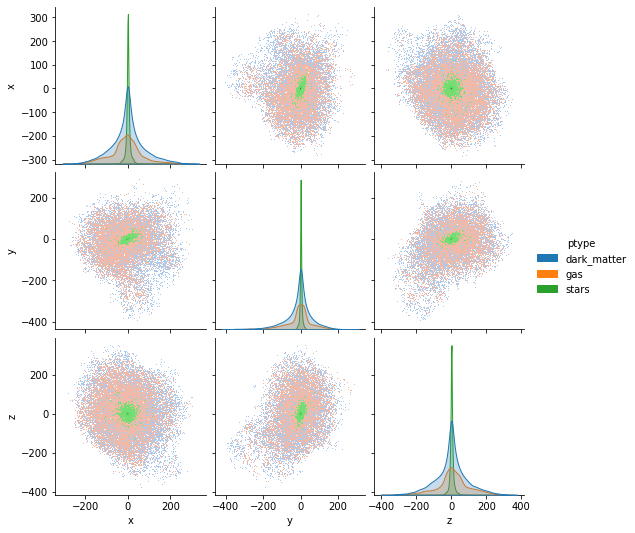

In [23]:
gal.plot.pairplot()

For more details about the galaxy plotting options see [Plotting Tutorial](index.rst).

Also, the user can see it in data frame format using the property [to_dataframe()](../api/core/data.rst#galaxychop.core.data.Galaxy.to_dataframe).
This method create Pandas DataFrames with the particle data.

In [24]:
gal.to_dataframe()

ptype  ptypev             m           x           y           z  \
0       stars       0  5.224283e+05    0.045630    0.023792   -0.036427   
1       stars       0  9.745897e+05   -0.094469    0.054867    0.006084   
2       stars       0  6.935776e+05   -0.172213   -0.000511    0.047600   
3       stars       0  1.070959e+06   -0.081766   -0.116694    0.177133   
4       stars       0  6.013803e+05    0.020734    0.023444    0.101449   
...       ...     ...           ...         ...         ...         ...   
272642    gas       2  1.429845e+06   44.246486 -253.661747 -240.888732   
272643    gas       2  1.436841e+06  -37.380023 -250.988099 -125.929722   
272644    gas       2  1.690580e+06   16.542737 -267.716920 -226.546536   
272645    gas       2  1.210975e+06 -220.426329   79.421367   46.584759   
272646    gas       2  1.023048e+06   95.365774  -72.813703  -55.119490   

               vx          vy         vz  softening      potential  \
0       10.773575   -6.878906 -20.425400        0.0 -195699.620206   
1       20.282349    8.661957  -7.947495        0.0 -196176.962277   
2      -14.897980    6.957092 -10.818886        0.0 -195152.120168   
3       -8.665253   -4.337433   5.506927        0.0 -194695.767625   
4       23.508469   -7.842865  -3.754723        0.0 -195703.942688   
...           ...         ...        ...        ...            ...   
272642 -44.183670 -152.597656  69.413803        0.0  -17314.963254   
272643 -69.019005  -67.030350  35.370728        0.0  -20910.620132   
272644 -61.974457 -122.167450  98.398193        0.0  -17358.735183   
272645 -96.530602   18.881409 -45.233887        0.0  -23427.833806   
272646  73.510818 -183.192642 -81.817543        0.0  -37321.182177   

        kinetic_energy   total_energy            Jx            Jy  \
0           290.293111 -195409.327095     -0.736533      0.539572   
1           274.782915 -195902.179362     -0.488759     -0.627390   
2           193.699612 -194958.420557     -0.325631     -2.572295   
3            62.113089 -194633.654536      0.125676     -1.084623   
4           314.128285 -195389.814402      0.707622      2.462754   
...                ...            ...           ...           ...   
272642    15028.258726   -2286.704528 -54366.682527   7572.031389   
272643     5253.889589  -15656.730543 -17318.744973  10013.702701   
272644    14223.961789   -3134.773394 -54019.473934  12412.323127   
272645     5860.384564  -17567.449242  -4472.122980 -14467.594426   
272646    22828.747471  -14492.434706  -4140.046679   3750.714504   

                  Jz  
0          -0.570209  
1          -1.931126  
2          -1.205710  
3          -0.656530  
4          -0.713749  
...              ...  
272642 -17959.617014  
272643 -14817.352798  
272644 -18612.594663  
272645   3504.632690  
272646 -12117.713187  

[272647 rows x 16 columns]

It is also possible to create the DataFrame the data only for a particular subset of particles:
 
Example of DataFrame using the particle set method for gas particles only:

In [25]:
gal.gas.to_dataframe()

ptype  ptypev             m           x           y           z  \
0       gas       2  2.579203e+06    0.255179   -0.317399   -0.722907   
1       gas       2  1.368585e+06    0.144436   -0.273204   -0.920894   
2       gas       2  1.392261e+06    0.436985   -0.442400   -0.524567   
3       gas       2  1.548436e+06    0.070196   -0.149943   -0.991583   
4       gas       2  1.936515e+06    0.458794   -0.134292   -0.716227   
...     ...     ...           ...         ...         ...         ...   
80148   gas       2  1.429845e+06   44.246486 -253.661747 -240.888732   
80149   gas       2  1.436841e+06  -37.380023 -250.988099 -125.929722   
80150   gas       2  1.690580e+06   16.542737 -267.716920 -226.546536   
80151   gas       2  1.210975e+06 -220.426329   79.421367   46.584759   
80152   gas       2  1.023048e+06   95.365774  -72.813703  -55.119490   

              vx          vy         vz  softening      potential  \
0       1.739517  -49.440781 -53.145966        0.0 -189770.988215   
1      -2.254318  -49.588120 -54.291103        0.0 -189253.154793   
2       9.799744  -51.434387 -54.606686        0.0 -189087.359395   
3       6.844009  -41.484070 -62.540501        0.0 -189119.151755   
4     -18.536072  -52.246674 -51.899296        0.0 -189389.528067   
...          ...         ...        ...        ...            ...   
80148 -44.183670 -152.597656  69.413803        0.0  -17314.963254   
80149 -69.019005  -67.030350  35.370728        0.0  -20910.620132   
80150 -61.974457 -122.167450  98.398193        0.0  -17358.735183   
80151 -96.530602   18.881409 -45.233887        0.0  -23427.833806   
80152  73.510818 -183.192642 -81.817543        0.0  -37321.182177   

       kinetic_energy   total_energy            Jx            Jy            Jz  
0         2635.955184 -187135.033032    -18.872611     12.304235    -12.064137  
1         2705.793726 -186547.361067    -30.832816      9.917571     -7.778194  
2         2861.710640 -186225.648755     -2.822747     18.721671    -18.140634  
3         2839.541367 -186279.610388    -31.757357     -2.396288     -1.885816  
4         2883.418881 -186506.109186    -30.450792     37.087136    -26.459731  
...               ...            ...           ...           ...           ...  
80148    15028.258726   -2286.704528 -54366.682527   7572.031389 -17959.617014  
80149     5253.889589  -15656.730543 -17318.744973  10013.702701 -14817.352798  
80150    14223.961789   -3134.773394 -54019.473934  12412.323127 -18612.594663  
80151     5860.384564  -17567.449242  -4472.122980 -14467.594426   3504.632690  
80152    22828.747471  -14492.434706  -4140.046679   3750.714504 -12117.713187  

[80153 rows x 16 columns]

Example of DataFrame for dark matter particles only, but using the Galaxy method:

In [26]:
gal.to_dataframe(ptypes=["dark_matter"])

ptype  ptypev             m           x           y           z  \
0       dark_matter       1  7.463453e+06   -0.199597   -0.133327    0.019300   
1       dark_matter       1  7.463453e+06   -0.193407    0.010379    0.323882   
2       dark_matter       1  7.463453e+06   -0.104725   -0.279349   -0.254531   
3       dark_matter       1  7.463453e+06   -0.035368    0.247132   -0.158874   
4       dark_matter       1  7.463453e+06    0.068567    0.201427    0.068706   
...             ...     ...           ...         ...         ...         ...   
155096  dark_matter       1  7.463453e+06  122.835357 -102.295263  119.148240   
155097  dark_matter       1  7.463453e+06   -3.807391 -112.662019 -170.243235   
155098  dark_matter       1  7.463453e+06  206.638302 -120.693961 -232.782225   
155099  dark_matter       1  7.463453e+06  106.611971   20.064196   70.304915   
155100  dark_matter       1  7.463453e+06 -162.065347   82.206626  188.792936   

                vx          vy          vz  softening      potential  \
0        27.392822  -28.606277  -11.712891        0.0 -194263.974644   
1         0.424881   16.078735  -21.107315        0.0 -193864.214478   
2        15.411789  -16.983276  -26.899292        0.0 -193553.979331   
3        -6.144241   41.590729    8.691856        0.0 -194863.484787   
4        41.559647  -31.797867   -8.205231        0.0 -195338.697452   
...            ...         ...         ...        ...            ...   
155096 -140.984707 -114.639359 -156.004555        0.0  -26943.758924   
155097 -110.969055 -128.893845  174.253159        0.0  -28608.222475   
155098 -148.566986   43.935516 -110.255395        0.0  -17664.029794   
155099 -204.087726  -41.703079 -198.017616        0.0  -38869.770346   
155100  -35.577972  -14.591019  193.043594        0.0  -22301.257349   

        kinetic_energy   total_energy            Jx            Jy  \
0           852.938814 -193411.035829      2.113754     -1.809165   
1           352.112502 -193512.101976     -5.426679     -3.944685   
2           624.763412 -192929.215919      3.191517     -6.739791   
3           921.544394 -193941.940393      8.755731      1.283574   
4          1402.817186 -193935.880266      0.531941      3.417993   
...                ...            ...           ...           ...   
155096    28678.145599    1734.386675  29617.604754   2364.795587   
155097    29645.958827    1037.736353 -41575.017780  19555.180952   
155098    18079.365585     415.335791  23534.567606  57366.741333   
155099    41300.961464    2431.191118  -1041.132809   6762.678314   
155100    19372.259635   -2928.997714  18624.143748  24568.807206   

                  Jz  
0           9.361922  
1          -3.114145  
2           6.083830  
3           0.047461  
4         -10.551514  
...              ...  
155096 -28503.834270  
155097 -12011.248486  
155098  -8852.377447  
155099   -351.191392  
155100   5289.443562  

[155101 rows x 16 columns]

Finally you can extract only a subset of the attributes:

In [27]:
gal.to_dataframe(
    ptypes=["dark_matter"], attributes=["ptype", "x", "total_energy"]
)

ptype           x   total_energy
0       dark_matter   -0.199597 -193411.035829
1       dark_matter   -0.193407 -193512.101976
2       dark_matter   -0.104725 -192929.215919
3       dark_matter   -0.035368 -193941.940393
4       dark_matter    0.068567 -193935.880266
...             ...         ...            ...
155096  dark_matter  122.835357    1734.386675
155097  dark_matter   -3.807391    1037.736353
155098  dark_matter  206.638302     415.335791
155099  dark_matter  106.611971    2431.191118
155100  dark_matter -162.065347   -2928.997714

[155101 rows x 3 columns]